### 1. INSTALL PACKAGES

####Packages

In [ ]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning
!pip install sentencepiece
!pip install datasets
!pip install rouge-score
!pip install tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 28.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.4 MB/s eta 0:00:

#### GPU

In [ ]:
#restore GPU
!pip install numba

from numba import cuda 
device = cuda.get_current_device()
device.reset()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


CudaSupportError: ignored

In [ ]:
!/opt/bin/nvidia-smi

### 2. IMPORT LIBRARIES

In [ ]:
import seaborn as sns 
from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer

import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import textwrap
from pathlib import Path

import json
import os
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt 
from matplotlib import rc 
import re
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer

#importing the data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 3. LOAD DATASET

In [ ]:
datapath = os.path.join("/content/drive/MyDrive/datasetRISET/INDOSUM/train_Indosum.csv")

#creating pandas dataframe using the data
data = pd.read_csv(datapath,encoding="latin-1")
data.head()

,paragraphs,summary
0,Merdeka.com - Pebalap tim pabrikan Ducati Cors...,Hal tersebut dirasakan mengingat dirinya sama ...
1,JUARA.net - Jerman akan mengambil alih posisi ...,Jerman akan mengambil alih posisi teratas daft...
2,Gempa berkekuatan 69 magnitudo meluluhkan ratu...,Gempa berkekuatan 69 magnitudo meluluhkan ratu...
3,JUARA.NET - Sudah empat tahun berlalu sejak Mi...,Sudah empat tahun berlalu sejak Michael Schuma...
4,JAKARTA ( Pos Kota ) ÃÂ Lima pengedar sabu j...,Lima pengedar sabu jaringan Malaysia digulung ...


In [ ]:
#renaming the columns
data.rename(columns={'paragraphs':"text"},inplace=True)

In [ ]:
#EDA 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8448 entries, 0 to 8447
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     8448 non-null   object
 1   summary  8448 non-null   object
dtypes: object(2)
memory usage: 132.1+ KB


In [ ]:
print("Number of rows in the data:",data.shape[0])

Number of rows in the data: 8448


In [ ]:
data.isna().sum()

text       0
summary    0
dtype: int64

### 3. PRE-PROCESSING DATA

In [ ]:
#function to remove numbers and punctuations in the data
#removing numbers and punctuations to get exact number of words in the data
def clean_text(text):
  text = text.lower()
  text = re.sub(pattern=r"[^a-zA-Z0-9_\s]",repl="",string=text)
  text = re.sub(pattern=r" {2,10}",repl=" ",string=text)
  return text

In [ ]:
cleaned_data=pd.DataFrame()
cleaned_data['text'] = data['text'].apply(clean_text)
cleaned_data['summary'] = data['summary'].apply(clean_text)

summary_lengths=[len(summary.split()) for summary in cleaned_data['summary']]
text_lengths=[len(text.split()) for text in cleaned_data['text']]

In [ ]:
cleaned_data.head(5)




,text,summary
0,merdekacom pebalap tim pabrikan ducati corse a...,hal tersebut dirasakan mengingat dirinya sama ...
1,juaranet jerman akan mengambil alih posisi ter...,jerman akan mengambil alih posisi teratas daft...
2,gempa berkekuatan 69 magnitudo meluluhkan ratu...,gempa berkekuatan 69 magnitudo meluluhkan ratu...
3,juaranet sudah empat tahun berlalu sejak micha...,sudah empat tahun berlalu sejak michael schuma...
4,jakarta pos kota lima pengedar sabu jaringan m...,lima pengedar sabu jaringan malaysia digulung ...


Text(0.5, 0.98, 'Distribution of words in summary and original text')

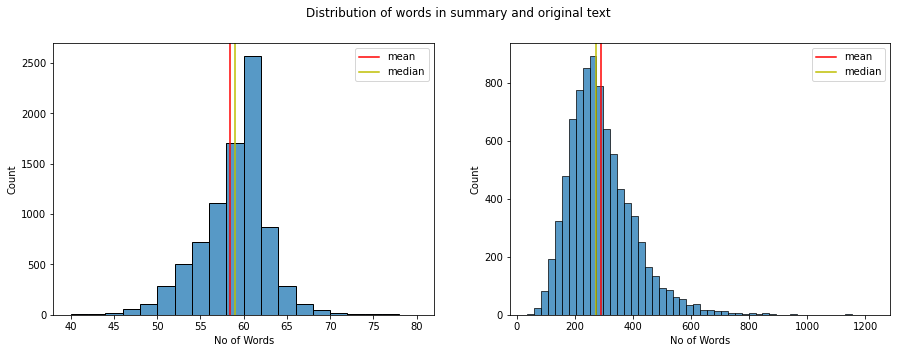

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(summary_lengths,bins=20)
plt.axvline(np.mean(summary_lengths),color="r",label="mean")
plt.axvline(np.median(summary_lengths),color="y",label="median")
plt.legend()
plt.xlabel("No of Words")
plt.subplot(1,2,2)
sns.histplot(text_lengths,bins=50)
plt.axvline(np.mean(text_lengths),color="r",label="mean")
plt.axvline(np.median(text_lengths),color="y",label="median")
plt.legend()
plt.xlabel("No of Words")
plt.suptitle("Distribution of words in summary and original text")

In [ ]:
#adding summarize: as prefix for the input sequence
#because the T5 model has been pretrained in the similar fashion for summarization tasks
data['text']=data['text'].apply(lambda x:"summarize: "+x)
data.head(5)

,text,summary
0,summarize: Merdeka.com - Pebalap tim pabrikan ...,Hal tersebut dirasakan mengingat dirinya sama ...
1,summarize: JUARA.net - Jerman akan mengambil a...,Jerman akan mengambil alih posisi teratas daft...
2,summarize: Gempa berkekuatan 69 magnitudo melu...,Gempa berkekuatan 69 magnitudo meluluhkan ratu...
3,summarize: JUARA.NET - Sudah empat tahun berla...,Sudah empat tahun berlalu sejak Michael Schuma...
4,summarize: JAKARTA ( Pos Kota ) ÃÂ Lima peng...,Lima pengedar sabu jaringan Malaysia digulung ...


In [ ]:
#splitting the data into train and validation split in the ratio (85:15)
split = int(len(data)/100*90)
training_data = data[:split]
valid_data = data[split:]

#saving the training and validation split into CSV
training_data.to_csv("indosum_training.csv")
valid_data.to_csv("indosum_validation.csv")

In [ ]:
training_data.shape[0]

7603

In [ ]:
valid_data.shape[0]

845

### 4. FUNCTION

In [ ]:
class NewsSummaryDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        text_max_token_len: int = 450,
        summary_max_token_len: int = 64):
        
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index:int):
        data_row = self.data.iloc[index]
        text = data_row["text"]
        
        text_encoding = tokenizer(data_row["text"],max_length=self.text_max_token_len,
                                 padding="max_length", 
                                 truncation=True,
                                 return_attention_mask=True,
                                 add_special_tokens=True,
                                 return_tensors="pt")
        
        summary = data_row["summary"]
        summary_encoding = tokenizer(summary,max_length=self.summary_max_token_len,
                                 padding="max_length", 
                                 truncation=True,
                                 return_attention_mask=True,
                                 add_special_tokens=True,
                                 return_tensors="pt")
        
        labels= summary_encoding["input_ids"] 
        labels[labels == 0] = -100
        
        return dict(
            text=text, 
            summary=summary,
            text_input_ids=text_encoding["input_ids"].flatten(),
            text_attention_mask=text_encoding["attention_mask"].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=summary_encoding["attention_mask"].flatten())

In [ ]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(self, 
                train_df:pd.DataFrame,
                test_df:pd.DataFrame,
                tokenizer:T5Tokenizer,
                batch_size: int = 8,
                text_max_token_len: int = 512,
                summary_max_token_len: int = 128):
        super().__init__()
        self.train_df=train_df
        self.test_df=test_df
        
        self.batch_size=batch_size
        self.tokenizer=tokenizer
        self.text_max_token_len=text_max_token_len
        self.summary_max_token_len= summary_max_token_len
    
    def setup(self, stage=None):
        self.train_dataset =  NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.test_dataset =  NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2)
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2)
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2)

### 5. MODELLING

#### Load Model Pretrained

In [ ]:
MODEL_NAME = "cahya/t5-base-indonesian-summarization-cased"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/793k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657 [00:00<?, ?B/s]

In [ ]:
tokenizer2 = T5Tokenizer.from_pretrained(MODEL_NAME)

In [ ]:
tokens2 = tokenizer2('aku cinta kucingku')


In [ ]:
tokens2

{'input_ids': [3359, 2919, 5850, 667, 1], 'attention_mask': [1, 1, 1, 1, 1]}

In [ ]:
tokens2 = tokens2['input_ids']

In [ ]:
[tokenizer2.decode(x) for x in tokens2]

['aku', 'cinta', 'kucing', 'ku', '</s>']

#### Hyperparameter

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 8

data_module = NewsSummaryDataModule(training_data,valid_data,tokenizer,batch_size=BATCH_SIZE)

#### Function for Model

In [ ]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
        
    def forward(self, inputs_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(inputs_ids,
                            attention_mask=attention_mask,
                            labels=labels,
                            decoder_attention_mask=decoder_attention_mask)
        return output.loss, output.logits
    
    def step(self, batch, batch_idx):
        input_ids=batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels=batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self.forward(inputs_ids=input_ids,
                             attention_mask=attention_mask,
                             decoder_attention_mask=labels_attention_mask,
                             labels=labels)
        return loss, outputs
    
    def training_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        
        self.log("train_loss",loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        self.log("val_loss",loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        self.log("test_loss",loss, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)
    

In [ ]:
model = NewsSummaryModel()

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

#### Training the Model

In [ ]:
from pytorch_lightning.callbacks import TQDMProgressBar

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint,EarlyStopping
from pytorch_lightning.plugins import DeepSpeedPlugin

In [ ]:
checkpoint_callback = ModelCheckpoint(
                        dirpath="checkpoints",
                        filename="best-checkpoint",
                        save_top_k=1,
                        verbose=True, 
                        monitor="val_loss",
                        mode="min")
logger = TensorBoardLogger("lightning_logs", name="t5_summary_indosum")


class LitProgressBar(TQDMProgressBar):

    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        bar.set_description('running validation ...')
        bar.refresh_rate=30
        return bar

bar = LitProgressBar()

trainer = pl.Trainer(logger=logger,
                    enable_checkpointing=checkpoint_callback,
                    max_epochs=N_EPOCHS,
                    gpus=1,
                    callbacks=[TQDMProgressBar(refresh_rate=10)])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model,data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
    )

In [ ]:
trained_model.freeze()

#### Summarize 

In [ ]:
def summarizeText(text):
    text_encoding = tokenizer(
        'summarize'+text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    generated_ids = trained_model.model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask=text_encoding['attention_mask'],
        max_length=128,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    preds = [
            tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for gen_id in generated_ids
    ]
    return "".join(preds)
    

In [ ]:
sample_row = valid_data.iloc[4]
text = sample_row['text']
model_summary = summarizeText(text)
text

'summarize: Jakarta  CNN Indonesia - - Ketua DPR RI Bambang Soesatyo atau Bamsoet mengatakan  revisi Undang - undang Nomor 17 Tahun 2014 tentang MPR  DPR  DPD  dan DPRD ( UU MD3 ) terkait penambahan jumlah kursi pimpinan dewan bukan merupakan politik balas budi untuk PDIP .]] Ia mengaku  revisi ini semata untuk mengakomodasi seluruh kekuatan politik yang ada di DPR untuk menempati kursi pimpinan .]] " Ini bukan balas budi atau bagi-bagi kue kekuasaan .] Ini soal mengakomodir seluruh kekuatan politik yang ada di DPR  " kata Bamsoet  di Kompleks Parlemen  Senayan  Jakarta Selatan  Kamis ( 8 / 2 ) .]] Dia mengingatkan  PDIP sebagai kekuatan politik terbesar dan partai pemenang pemilu 2014 belum mendapatkan kursi pimpinan DPR .] Bagi Bamsoet  tak sepantasnya PDIP tak mendapatkan kursi pimpinan .]] " Tak elok juga kalau ada satu partai pemenang pemilu  partai besar  yang tak terakomodir di pimpinan DPR atau MPR  " tambah dia .]] Selain itu  Bamsoet menyebut  inisiatif untuk merevisi UU MD3 

In [ ]:
sample_row['summary']

'Ketua DPR RI Bambang Soesatyo atau Bamsoet mengatakan  revisi Undang - undang Nomor 17 Tahun 2014 tentang UU MD3 terkait penambahan jumlah kursi pimpinan dewan bukan merupakan politik balas budi untuk PDIP .] Dia mengingatkan  PDIP sebagai kekuatan politik terbesar dan partai pemenang pemilu 2014 belum mendapatkan kursi pimpinan DPR .] Bagi Bamsoet  tak sepantasnya PDIP tak mendapatkan kursi pimpinan .]]'

In [ ]:
model_summary

'Ketua DPR RI Bambang Soesatyo atau Bamsoet mengatakan revisi Undang - undang Nomor 17 Tahun 2014 tentang MPR DPR DPD dan DPRD ( UU MD3 ) terkait penambahan jumlah kursi pimpinan dewan bukan merupakan politik balas budi untuk PDIP.] Ia mengaku revisi ini semata untuk mengakomodasi seluruh kekuatan politik yang ada di DPR untuk menempati kursi pimpinan.]]'

#### Saving Model with Pickle

In [ ]:
import pickle

In [ ]:
filename = open('text_t5_model.pkl', 'wb')
pickle.dump(trained_model.model, filename)

In [ ]:
!cp -r 'text_t5_model.pkl' /content/drive/MyDrive/datasetRISET/model

In [ ]:
# saving the model
model = pickle.load(open('/content/drive/MyDrive/datasetRISET/model/text_t5_model.pkl', 'rb'))

In [ ]:
# function for producing output provided input
def summarizeText(text):
    text_encoding = tokenizer(
        'summarize'+text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    generated_ids = model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask=text_encoding['attention_mask'],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    preds = [
            tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for gen_id in generated_ids
    ]
    return "".join(preds)

### 6. EVALUATING DATA TEST

#### Load Data test

In [ ]:
datapath = os.path.join("/content/drive/MyDrive/datasetRISET/INDOSUM/test_Indosum.csv")

data_test = pd.read_csv(datapath,encoding="latin-1")
data_test.head()

,paragraphs,summary
0,Jakarta CNN Indonesia - - Bayern Munich menja...,Bayern Munich menjadi klub raksasa Eropa teran...
1,Merdeka.com - Catatan tak pernah kalah yang di...,Catatan tak pernah kalah yang dirangkum oleh P...
2,Instagram Stories adalah candu baru buat merek...,Kita mungkom telah banyak melihat ada teman ya...
3,Pemerintah bersama dengan Kepolisian RI TNI ...,Pemerintah bersama dengan Kepolisian RI TNI ...
4,Mantan Bupati Buton Samsu Umar Abdul Samiun d...,Mantan Bupati Buton Samsu Umar Abdul Samiun d...


In [ ]:
data_test.columns=['text','summary']

In [ ]:
predicted_summary = []

list_counter = []
for row in data_test.index:
  predicted_summary.append(summarizeText(data_test['text'][row]))


  list_counter.append(row)
  if len(list_counter) == 939:
    break

In [ ]:
list_article = data_test['text'].head(939)
list_reference = data_test['summary'].head(939)
df_test_result = pd.DataFrame({'text':list_article,'summary':list_reference,'model_summary':predicted_summary})
df_test_result.head(939)

,text,summary,model_summary
0,Jakarta CNN Indonesia - - Bayern Munich menja...,Bayern Munich menjadi klub raksasa Eropa teran...,Bayern Munich menjadi klub raksasa Eropa teran...
1,Merdeka.com - Catatan tak pernah kalah yang di...,Catatan tak pernah kalah yang dirangkum oleh P...,Catatan tak pernah kalah yang dirangkum oleh P...
2,Instagram Stories adalah candu baru buat merek...,Kita mungkom telah banyak melihat ada teman ya...,Instagram Stories adalah candu baru buat merek...
3,Pemerintah bersama dengan Kepolisian RI TNI ...,Pemerintah bersama dengan Kepolisian RI TNI ...,Pemerintah bersama dengan Kepolisian RI TNI Ja...
4,Mantan Bupati Buton Samsu Umar Abdul Samiun d...,Mantan Bupati Buton Samsu Umar Abdul Samiun d...,Bupati Buton Samsu Umar Abdul Samiun divonis 3...
...,...,...,...
934,Libur long weekend jelang Idul Adha yang jatuh...,Libur long weekend Idul Adha pada Jumat ( 1 / ...,Sejak Kamis ( 31 / 8 ) pagi kepadatan sudah mu...
935,Jakarta CNN Indonesia - - Menteri Pertahanan ...,Menteri Pertahanan AS James Mattis dan Menteri...,Menteri Pertahanan AS James Mattis dan menteri...
936,Jakarta CNN Indonesia - - Bukan hanya nasib p...,Aoyama Gosho memang sudah berbakat sejak kecil...,Bakat Aoyama menggambar sudah terlihat sejak k...
937,Merdeka.com - Teka - teki masa depan Cristiano...,Teka - teki masa depan Cristiano Ronaldo terus...,Teka - teki masa depan Cristiano Ronaldo terus...


In [ ]:
df_test_result.to_csv("(2)summarize all row.csv",index=False)

In [ ]:
refer =[]
list_count_ref =[]

for row in df_test_result.index:
  refer.append(df_test_result['summary'][row])

  list_count_ref.append(row)
  if len(list_count_ref) == 939:
    break


In [ ]:
refer

['Bayern Munich menjadi klub raksasa Eropa teranyar yang berusaha mendapatkan penyerang Inter Milan  Mauro Icardi .] Pihak Bayern dikabarkan sudah melakukan pendekatan dengan manajemen Inter Milan .] Dikutip dari FCInterNews.it  manajemen Bayern sudah menghubungi pihak Inter dan membicarakan masalah transfer Icardi .] Pihak Inter dikabarkan sedang kesulitan menahan kepindahan Icardi dari Stadion Giuseppe Meazza .]]',
 'Catatan tak pernah kalah yang dirangkum oleh PS TNI di Stadion Pakansari akhirnya runtuh .] Untuk pertama kalinya PS TNI mengalami kekalahan di kandang sendiri saat menjamu Persija  Jakarta  pada Kamis  ( 8 / 6 ) malam WIB .] Pada lanjutan pekan ke - 10 Liga 1 ini  laga berjalan cukup seimbang .] Sejak menit pertama  kedua tim silih berganti melepas serangan .] Skor 2 - 0 bertahan hingga laga usai .]]',
 'Kita mungkom telah banyak melihat ada teman yang membagikan banyak sekali video Instagram Stories .] Ini membuat tanda di bagian atas video Stories bukan lagi berbentuk

#### Rouge

In [ ]:
!pip install rouge
from rouge import Rouge

rouge = Rouge()
scores2 = rouge.get_scores(predicted_summary, refer)
df_result2 = pd.DataFrame(scores2)
df_result2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,rouge-1,rouge-2,rouge-l
0,"{'r': 0.7317073170731707, 'p': 0.625, 'f': 0.6...","{'r': 0.6538461538461539, 'p': 0.53125, 'f': 0...","{'r': 0.7317073170731707, 'p': 0.625, 'f': 0.6..."
1,"{'r': 0.9047619047619048, 'p': 1.0, 'f': 0.949...","{'r': 0.8571428571428571, 'p': 0.9836065573770...","{'r': 0.9047619047619048, 'p': 1.0, 'f': 0.949..."
2,"{'r': 0.2727272727272727, 'p': 0.3061224489795...","{'r': 0.09375, 'p': 0.0967741935483871, 'f': 0...","{'r': 0.23636363636363636, 'p': 0.265306122448..."
3,"{'r': 0.7090909090909091, 'p': 0.5342465753424...","{'r': 0.6440677966101694, 'p': 0.4634146341463...","{'r': 0.7090909090909091, 'p': 0.5342465753424..."
4,"{'r': 0.625, 'p': 0.6481481481481481, 'f': 0.6...","{'r': 0.5161290322580645, 'p': 0.4776119402985...","{'r': 0.625, 'p': 0.6481481481481481, 'f': 0.6..."
...,...,...,...
934,"{'r': 0.6271186440677966, 'p': 0.7115384615384...","{'r': 0.4166666666666667, 'p': 0.5, 'f': 0.454...","{'r': 0.6271186440677966, 'p': 0.7115384615384..."
935,"{'r': 0.9583333333333334, 'p': 0.6969696969696...","{'r': 0.8867924528301887, 'p': 0.5875, 'f': 0....","{'r': 0.9583333333333334, 'p': 0.6969696969696..."
936,"{'r': 0.6037735849056604, 'p': 0.7272727272727...","{'r': 0.5084745762711864, 'p': 0.5660377358490...","{'r': 0.6037735849056604, 'p': 0.7272727272727..."
937,"{'r': 0.5882352941176471, 'p': 0.5454545454545...","{'r': 0.5084745762711864, 'p': 0.4615384615384...","{'r': 0.5882352941176471, 'p': 0.5454545454545..."


In [ ]:
df_result2.to_csv("(2)rouge  all baris.csv")

In [ ]:
!cp -r 'text_t5_model.pkl' /content/drive/MyDrive/datasetRISET/model

In [ ]:
def calc_metrics(preds,actual):
  metrics=['rouge1','rouge2','rougeL']
  result={metrics[0]:[],metrics[1]:[],metrics[2]:[]}
  for metric in metrics:
    precision=[]
    recall=[]
    f1=[]
    scorer = rouge_scorer.RougeScorer([metric],use_stemmer=True)
    for x,y in zip(predicted_summary, refer):
      scores = scorer.score(x,y)
      precision.append(scores[metric][0])
      recall.append(scores[metric][1])
      f1.append(scores[metric][2])
    result[metric].append(np.mean(precision))
    result[metric].append(np.mean(recall))
    result[metric].append(np.mean(f1))
  return pd.DataFrame(result,index=['Precision','Recall','F1-Score'])

In [ ]:
scores=calc_metrics(predicted_summary, refer)
scores

,rouge1,rouge2,rougeL
Precision,0.740705,0.661741,0.707032
Recall,0.685995,0.611624,0.654449
F1-Score,0.709874,0.633455,0.677403


In [ ]:
scores.to_csv("score rouge all.csv", index=None)